In [2]:
# import packages
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn
from helper import *
import ipywidgets as widgets

# variables
time_period = (1, 2, 3, 4, 5) # 5 different implementation of progression order  
n_patients = 0 # number of patients included in the model  
n_sessions = 0 # number of sessions included in the model  
usage_time: how many months the patient has been using the app  
usage_freq: how frequent the patient uses the app  

Clean Data

In [3]:
# querying from the SQL database, 2 mins for q3 table

# from connection import *

# con = connect()
# df = SQL("select * from constant_therapy.q3", con)
# df = df.rename(columns={'session_id':"id"})

In [4]:
# 1 min, data saved from previous runs
df = pd.read_csv("data/context_action_w_ds.csv")
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,domain_id,condition_since,birth_year,deficit_id,start_time,start_time_min,end_time,end_time_min,disorder_id
0,9164637,19990,20,1,2,1.0,1,1y,1975,1,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}"
1,9164637,19990,20,1,2,1.0,1,1y,1975,3,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}"
2,9164637,19990,20,1,2,1.0,1,1y,1975,4,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}"
3,9164637,19990,20,1,2,1.0,1,1y,1975,5,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}"
4,9164637,19990,20,1,2,1.0,1,1y,1975,6,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}"


In [5]:
# 20 seconds
deficit_ids = df.groupby("patient_id")["deficit_id"].apply(set).reset_index()
df = df.drop(columns="deficit_id")
df = df.merge(deficit_ids, on="patient_id", how="left")

In [6]:
# 1 min
domain_ids = df.groupby("id")["domain_id"].apply(set).reset_index()
df = df.drop(columns="domain_id")
df = df.merge(domain_ids, on="id", how="left")

In [7]:
df = df.drop_duplicates(subset="id")

In [8]:
# df.to_csv("data/consolidate_data_w_ds.csv", index=False)
## careful when reading, will read set as string
# df = pd.read_csv("data/consolidate_data.csv", index_col=[0])
df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
0,9164637,19990,20,1,2,1.000,1y,1975,2017-11-22,2017-11-22 22:56:27,2017-11-22,2017-11-22 22:56:34,"{2, 3}","{1, 3, 4, 5, 6, 7, 8}",{1}
28,9164638,19990,21,1,2,0.813,1y,1975,2017-11-22,2017-11-22 22:56:48,2017-11-22,2017-11-22 22:57:04,"{2, 3}","{1, 3, 4, 5, 6, 7, 8}",{1}
35,9159805,19990,37,1,2,0.875,1y,1975,2017-11-22,2017-11-22 17:04:56,2017-11-22,2017-11-22 17:05:11,"{2, 3}","{1, 3, 4, 5, 6, 7, 8}","{1, 10, 11}"
63,9164253,19990,68,1,2,0.000,1y,1975,2017-11-22,2017-11-22 22:22:03,2017-11-22,2017-11-22 22:22:05,"{2, 3}","{1, 3, 4, 5, 6, 7, 8}","{1, 13}"
98,9164465,19990,11,1,2,0.000,1y,1975,2017-11-22,2017-11-22 22:42:57,2017-11-22,2017-11-22 22:43:05,"{2, 3}","{1, 3, 4, 5, 6, 7, 8}",{2}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83666773,18186629,298023,28,4,6,0.833,1y,1995,2019-06-11,2019-06-11 14:25:03,2019-06-11,2019-06-11 14:28:07,"{2, 3, 6}","{9, 3}",{14}
83666781,20932209,347856,28,4,3,0.000,>10y,1985,2019-11-06,2019-11-06 14:25:45,2019-11-06,2019-11-06 14:26:51,{9},{3},{14}
83666785,14061511,217018,7,5,10,0.908,6m,1943,2018-11-05,2018-11-05 15:52:25,2018-11-05,2018-11-05 16:08:50,"{3, 6}",{3},{14}
83666786,14062555,217018,7,5,10,0.978,6m,1943,2018-11-05,2018-11-05 16:16:53,2018-11-05,2018-11-05 16:27:40,"{3, 6}",{3},{14}


All data has been consolidated, there should be no duplicate sessions for different disorders/domains.
We want to add time_period, usage_time, and usage_freq to the dataset.

**This part doesn't need to be run if it's claire's data**

In [9]:
# progression_order_df = pd.read_csv("data/progression_order.csv", index_col=[0])
# progression_order_df.rename(columns={'time_implemented':'start_time'}, inplace=True)
# progression_order_df["start_time"] = pd.to_datetime(progression_order_df["start_time"])
# df["start_time"] = pd.to_datetime(df["start_time"])

In [10]:
# def time_period_convert(dd):
#     dates = sorted(pd.unique(progression_order_df["start_time"]))
#     if dd < pd.to_datetime(dates[1]):
#         return 1
#     elif dd < pd.to_datetime(dates[2]):
#         return 2
#     elif dd < pd.to_datetime(dates[3]):
#         return 3
#     elif dd < pd.to_datetime(dates[4]):
#         return 4
#     else:
#         return 5

In [11]:
# added time period, takes around 8-9 minutes to run
# df["time_period"] = df["start_time"].apply(time_period_convert)
# df

In [12]:
# progression_order_df["time_period"] = progression_order_df["start_time"].apply(time_period_convert)
# progression_order_df

Adding Usage Time
* this is by patient
* need a patient dataframe vs session dataframe (df)

In [13]:
df["start_time"] = pd.to_datetime(df["start_time"])

In [14]:
patients = (df.groupby("patient_id")["start_time"].max() - df.groupby("patient_id")["start_time"].min()).reset_index()
patients.columns = ["patient_id", "usage_time"]
patients["usage_time"] = patients["usage_time"].dt.days + 1
patients

,patient_id,usage_time
0,14696,944
1,15224,1
2,15436,1
3,15671,927
4,15796,859
...,...,...
65696,416292,22
65697,417407,12
65698,417817,1
65699,417855,7


Add usage_freq for patient dataframe
* using the simplest way of calculating frequency
* how to get rid of outlier

In [15]:
patients["session_count"] = df.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients["unique_days"] = df.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients

,patient_id,usage_time,session_count,unique_days
0,14696,944,4231,766
1,15224,1,2,1
2,15436,1,9,1
3,15671,927,156,55
4,15796,859,392,61
...,...,...,...,...
65696,416292,22,26,14
65697,417407,12,9,6
65698,417817,1,1,1
65699,417855,7,12,4


In [16]:
patients["usage_freq"] = patients["unique_days"] / patients["usage_time"]
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14696,944,4231,766,0.811441
1,15224,1,2,1,1.000000
2,15436,1,9,1,1.000000
3,15671,927,156,55,0.059331
4,15796,859,392,61,0.071013
...,...,...,...,...,...
65696,416292,22,26,14,0.636364
65697,417407,12,9,6,0.500000
65698,417817,1,1,1,1.000000
65699,417855,7,12,4,0.571429


How to remove outlier

In [17]:
# modified from https://stackoverflow.com/questions/56750841/how-to-trim-outliers-in-dates-in-python
def datetime_outlier(data):
    qa = data["start_time"].quantile(0.2) #lower 10%
    qb = data["start_time"] #higher 10%
    #remove outliers
    xf = data[(data.start_time >= qa) & (data.start_time <= qb)]
    return xf

In [18]:
# about a min
patients_v2 = df.groupby("patient_id").apply(datetime_outlier).reset_index(drop=True)

In [19]:
patients_v2

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
0,10701369,14696,21,2,10,0.959,2y,1937,2018-03-22,2018-03-22 13:42:41,2018-03-22,2018-03-22 13:46:40,{2},"{1, 3, 4, 5, 6, 8}",{1}
1,10722587,14696,21,2,10,0.970,2y,1937,2018-03-23,2018-03-23 16:57:36,2018-03-23,2018-03-23 17:01:01,{2},"{1, 3, 4, 5, 6, 8}",{1}
2,10731593,14696,21,2,10,0.940,2y,1937,2018-03-24,2018-03-24 13:22:14,2018-03-24,2018-03-24 13:25:52,{2},"{1, 3, 4, 5, 6, 8}",{1}
3,10972349,14696,21,2,10,0.920,2y,1937,2018-04-10,2018-04-10 20:28:14,2018-04-10,2018-04-10 20:32:19,{2},"{1, 3, 4, 5, 6, 8}",{1}
4,10978253,14696,21,2,10,0.860,2y,1937,2018-04-11,2018-04-11 12:59:06,2018-04-11,2018-04-11 13:02:58,{2},"{1, 3, 4, 5, 6, 8}",{1}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407254,25201475,417855,26,4,6,0.547,1y,2003,2020-06-30,2020-06-30 20:54:43,2020-06-30,2020-06-30 21:04:00,{7},"{10, 5, 6, 7}",{5}
2407255,25145133,417855,15,3,1,1.000,1y,2003,2020-06-29,2020-06-29 20:15:55,2020-06-29,2020-06-29 20:15:55,{7},"{10, 5, 6, 7}",{9}
2407256,25201470,417855,15,4,2,1.000,1y,2003,2020-06-30,2020-06-30 20:41:46,2020-06-30,2020-06-30 20:41:51,{7},"{10, 5, 6, 7}",{9}
2407257,25208970,417855,15,5,1,1.000,1y,2003,2020-06-30,2020-06-30 21:31:06,2020-06-30,2020-06-30 21:31:06,{7},"{10, 5, 6, 7}",{9}


In [20]:
patients_filtered = (patients_v2.groupby("patient_id")["start_time"].max() - patients_v2.groupby("patient_id")["start_time"].min()).reset_index()
patients_filtered.columns = ["patient_id", "usage_time"]
patients_filtered["usage_time"] = patients_filtered["usage_time"].dt.days + 1
patients_filtered

,patient_id,usage_time
0,14696,838
1,15224,1
2,15436,1
3,15671,836
4,15796,797
...,...,...
65696,416292,14
65697,417407,10
65698,417817,1
65699,417855,2


In [21]:
patients_filtered["session_count"] = patients_v2.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients_filtered["unique_days"] = patients_v2.groupby("patient_id")["start_time"].nunique().reset_index(name="days")["days"]
patients_filtered["usage_freq"] = patients_filtered["unique_days"] / patients_filtered["usage_time"]

Check that the length of patients_filtered is less than or equal to the length of patients

In [22]:
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14696,944,4231,766,0.811441
1,15224,1,2,1,1.000000
2,15436,1,9,1,1.000000
3,15671,927,156,55,0.059331
4,15796,859,392,61,0.071013
...,...,...,...,...,...
65696,416292,22,26,14,0.636364
65697,417407,12,9,6,0.500000
65698,417817,1,1,1,1.000000
65699,417855,7,12,4,0.571429


In [23]:
patients_filtered

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14696,838,3387,673,0.803103
1,15224,1,2,1,1.000000
2,15436,1,9,1,1.000000
3,15671,836,125,51,0.061005
4,15796,797,316,52,0.065245
...,...,...,...,...,...
65696,416292,14,21,9,0.642857
65697,417407,10,8,5,0.500000
65698,417817,1,1,1,1.000000
65699,417855,2,9,2,1.000000


## INTERACT
Filter seems to work for time outlier, so we using patient_filtered

In [24]:
# interact to figure out what thresholds to use

@widgets.interact_manual(usage_time=(1, 365), usage_freq=(0.0, 1.0))
def visualize(usage_time, usage_freq):
    temp = patients_filtered[patients_filtered.usage_time > usage_time]
    temp = temp[temp.usage_freq > usage_freq]
    return "number of patients: %d" %(temp["patient_id"].nunique())

interactive(children=(IntSlider(value=183, description='usage_time', max=365, min=1), FloatSlider(value=0.5, d…

In [25]:
# create the according filtered patients dataframe

usage_time = input("usage time: ")
print("inputted ", usage_time)
usage_freq = input("usage_freq: ")
print("inputted ", usage_freq)

inputted  60
inputted  0.1


In [26]:
filtered_patients_list = patients_filtered[patients_filtered.usage_time > float(usage_time)]
filtered_patients_list = filtered_patients_list[filtered_patients_list.usage_freq > float(usage_freq)]

In [27]:
filtered_patients_list.nunique()

patient_id       4448
usage_time        783
session_count    1153
unique_days       442
usage_freq       3451
dtype: int64

In [28]:
# create filtered session dataframe from filtered patients data
temp_lst = filtered_patients_list["patient_id"]
sessions_filter_df = df[df.patient_id.isin(temp_lst)]
sessions_filter_df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
2583,9256459,143524,20,1,10,0.788,2y,1971,2017-12-02,2017-12-02 13:28:49,2017-12-06,2017-12-06 16:17:47,{1},"{1, 2, 3, 5, 6, 8}",{1}
2589,9319566,143524,20,1,10,0.825,2y,1971,2017-12-08,2017-12-08 11:22:58,2017-12-08,2017-12-08 11:26:29,{1},"{1, 2, 3, 5, 6, 8}",{1}
2595,9346944,143524,20,1,10,0.862,2y,1971,2017-12-11,2017-12-11 11:47:19,2017-12-18,2017-12-18 13:20:08,{1},"{1, 2, 3, 5, 6, 8}",{1}
2655,9524559,143524,20,3,5,0.867,2y,1971,2017-12-24,2017-12-24 14:11:56,2017-12-24,2017-12-24 14:15:18,{1},"{1, 2, 3, 5, 6, 8}",{1}
2661,9525898,143524,20,3,6,0.833,2y,1971,2017-12-24,2017-12-24 16:38:01,2017-12-24,2017-12-24 16:48:16,{1},"{1, 2, 3, 5, 6, 8}",{1}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83654008,19768354,312036,24,5,3,0.948,1y,1956,2019-09-05,2019-09-05 23:40:37,2019-09-05,2019-09-05 23:41:22,{2},"{8, 5, 6, 7}",{12}
83654012,19770319,312036,24,5,3,0.749,1y,1956,2019-09-20,2019-09-20 03:42:08,2019-09-20,2019-09-20 03:54:10,{2},"{8, 5, 6, 7}",{12}
83654016,20071746,312036,24,5,3,0.853,1y,1956,2019-09-22,2019-09-22 20:02:43,2019-09-22,2019-09-22 20:06:42,{2},"{8, 5, 6, 7}",{12}
83654020,20160407,312036,24,5,3,0.853,1y,1956,2019-09-26,2019-09-26 19:52:09,2019-09-26,2019-09-26 19:56:19,{2},"{8, 5, 6, 7}",{12}


In [29]:
# filter based on time_period
# time_period_n = input("time period: ")
# sessions_filter_df = sessions_filter_df[sessions_filter_df.time_period == int(time_period_n)]

In [30]:
# sessions_filter_df.to_csv("data/PLACEHOLDER.csv")

In [31]:
sessions_filter_df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
2583,9256459,143524,20,1,10,0.788,2y,1971,2017-12-02,2017-12-02 13:28:49,2017-12-06,2017-12-06 16:17:47,{1},"{1, 2, 3, 5, 6, 8}",{1}
2589,9319566,143524,20,1,10,0.825,2y,1971,2017-12-08,2017-12-08 11:22:58,2017-12-08,2017-12-08 11:26:29,{1},"{1, 2, 3, 5, 6, 8}",{1}
2595,9346944,143524,20,1,10,0.862,2y,1971,2017-12-11,2017-12-11 11:47:19,2017-12-18,2017-12-18 13:20:08,{1},"{1, 2, 3, 5, 6, 8}",{1}
2655,9524559,143524,20,3,5,0.867,2y,1971,2017-12-24,2017-12-24 14:11:56,2017-12-24,2017-12-24 14:15:18,{1},"{1, 2, 3, 5, 6, 8}",{1}
2661,9525898,143524,20,3,6,0.833,2y,1971,2017-12-24,2017-12-24 16:38:01,2017-12-24,2017-12-24 16:48:16,{1},"{1, 2, 3, 5, 6, 8}",{1}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83654008,19768354,312036,24,5,3,0.948,1y,1956,2019-09-05,2019-09-05 23:40:37,2019-09-05,2019-09-05 23:41:22,{2},"{8, 5, 6, 7}",{12}
83654012,19770319,312036,24,5,3,0.749,1y,1956,2019-09-20,2019-09-20 03:42:08,2019-09-20,2019-09-20 03:54:10,{2},"{8, 5, 6, 7}",{12}
83654016,20071746,312036,24,5,3,0.853,1y,1956,2019-09-22,2019-09-22 20:02:43,2019-09-22,2019-09-22 20:06:42,{2},"{8, 5, 6, 7}",{12}
83654020,20160407,312036,24,5,3,0.853,1y,1956,2019-09-26,2019-09-26 19:52:09,2019-09-26,2019-09-26 19:56:19,{2},"{8, 5, 6, 7}",{12}


In [32]:
sessions_filter_df[["id", "patient_id"]].nunique()

id            2194134
patient_id       4448
dtype: int64

Check if there are any duplicate domain ids for each session

In [33]:
sessions_filter_df[sessions_filter_df["domain_id"].apply(lambda x: len(x) != 1)]

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
4959,9319561,143524,37,1,10,0.837,2y,1971,2017-12-07,2017-12-07 11:50:37,2017-12-07,2017-12-07 11:56:48,{1},"{1, 2, 3, 5, 6, 8}","{1, 10, 11}"
4965,9346939,143524,37,1,10,0.925,2y,1971,2017-12-10,2017-12-10 03:01:18,2017-12-10,2017-12-10 11:43:04,{1},"{1, 2, 3, 5, 6, 8}","{1, 10, 11}"
4971,9455355,143524,37,1,10,0.888,2y,1971,2017-12-18,2017-12-18 13:45:34,2017-12-18,2017-12-18 13:50:06,{1},"{1, 2, 3, 5, 6, 8}","{1, 10, 11}"
4977,9610755,143524,37,1,7,0.786,2y,1971,2018-01-02,2018-01-02 15:06:21,2018-01-02,2018-01-02 15:09:35,{1},"{1, 2, 3, 5, 6, 8}","{1, 10, 11}"
4983,9659102,143524,37,1,7,0.893,2y,1971,2018-01-08,2018-01-08 23:06:27,2018-01-08,2018-01-08 23:09:20,{1},"{1, 2, 3, 5, 6, 8}","{1, 10, 11}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83653588,19770320,312036,87,3,5,0.914,1y,1956,2019-09-20,2019-09-20 03:54:35,2019-09-20,2019-09-20 03:55:27,{2},"{8, 5, 6, 7}","{12, 13}"
83653592,20071747,312036,87,3,5,1.000,1y,1956,2019-09-22,2019-09-22 20:06:57,2019-09-22,2019-09-22 20:07:47,{2},"{8, 5, 6, 7}","{12, 13}"
83653596,20118768,312036,87,3,5,1.000,1y,1956,2019-09-24,2019-09-24 22:31:37,2019-09-26,2019-09-26 19:36:46,{2},"{8, 5, 6, 7}","{12, 13}"
83653600,20160408,312036,87,3,5,1.000,1y,1956,2019-09-26,2019-09-26 19:56:44,2019-09-26,2019-09-26 19:57:52,{2},"{8, 5, 6, 7}","{12, 13}"


Now that we have the filtered dataframe, we want to start performance metric calculation
* add progression order  
**for now**  
* calculate percentile of each session for each domain
* for each patient, average percentile value across all domains **at the time**, which is our final performance metric calculation

This part doesn not need to be run if it's claire's data

In [34]:
# expand sessions due to compressed domain
sessions_filter_df = sessions_filter_df.explode("domain_id").reset_index()

In [32]:
# progression_order_df[progression_order_df.time_period == int(time_period_n)]

,domain_id,root_id,task_type_id,task_level,progression_order,start_time,time_period
871,1,20,20,1,0,2019-10-08,5
872,1,20,20,2,1,2019-10-08,5
873,1,20,20,3,2,2019-10-08,5
874,1,20,20,4,3,2019-10-08,5
875,1,20,20,5,4,2019-10-08,5
...,...,...,...,...,...,...,...
1170,14,6,6,5,25,2019-10-08,5
1171,14,29,174,6,26,2019-10-08,5
1172,14,7,169,6,27,2019-10-08,5
1173,14,28,173,6,28,2019-10-08,5


In [35]:
sessions_filter_df.dtypes

index                            int64
id                               int64
patient_id                       int64
task_type_id                     int64
task_level                       int64
completed_task_count             int64
accuracy                       float64
condition_since                 object
birth_year                       int64
start_time              datetime64[ns]
start_time_min                  object
end_time                        object
end_time_min                    object
disorder_id                     object
deficit_id                      object
domain_id                       object
dtype: object

In [36]:
def set_to_int(s):
    if isinstance(s, int): return s
    return s.pop()

In [37]:
sessions_filter_df["domain_id"] = sessions_filter_df["domain_id"].apply(set_to_int)
sessions_filter_df

,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,disorder_id,deficit_id,domain_id
0,2583,9256459,143524,20,1,10,0.788,2y,1971,2017-12-02,2017-12-02 13:28:49,2017-12-06,2017-12-06 16:17:47,{1},"{1, 2, 3, 5, 6, 8}",1
1,2589,9319566,143524,20,1,10,0.825,2y,1971,2017-12-08,2017-12-08 11:22:58,2017-12-08,2017-12-08 11:26:29,{1},"{1, 2, 3, 5, 6, 8}",1
2,2595,9346944,143524,20,1,10,0.862,2y,1971,2017-12-11,2017-12-11 11:47:19,2017-12-18,2017-12-18 13:20:08,{1},"{1, 2, 3, 5, 6, 8}",1
3,2655,9524559,143524,20,3,5,0.867,2y,1971,2017-12-24,2017-12-24 14:11:56,2017-12-24,2017-12-24 14:15:18,{1},"{1, 2, 3, 5, 6, 8}",1
4,2661,9525898,143524,20,3,6,0.833,2y,1971,2017-12-24,2017-12-24 16:38:01,2017-12-24,2017-12-24 16:48:16,{1},"{1, 2, 3, 5, 6, 8}",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138888,83654008,19768354,312036,24,5,3,0.948,1y,1956,2019-09-05,2019-09-05 23:40:37,2019-09-05,2019-09-05 23:41:22,{2},"{8, 5, 6, 7}",12
3138889,83654012,19770319,312036,24,5,3,0.749,1y,1956,2019-09-20,2019-09-20 03:42:08,2019-09-20,2019-09-20 03:54:10,{2},"{8, 5, 6, 7}",12
3138890,83654016,20071746,312036,24,5,3,0.853,1y,1956,2019-09-22,2019-09-22 20:02:43,2019-09-22,2019-09-22 20:06:42,{2},"{8, 5, 6, 7}",12
3138891,83654020,20160407,312036,24,5,3,0.853,1y,1956,2019-09-26,2019-09-26 19:52:09,2019-09-26,2019-09-26 19:56:19,{2},"{8, 5, 6, 7}",12


get domain scores

In [49]:
domain_scores = pd.read_csv("data/domain_score.csv")
domain_scores.pop(domain_scores.columns[0])
domain_scores.head()

,id,type,schedule_id,patient_id,clinician_id,parent_id,start_time,end_time,duration,is_baseline,...,skipped_response_count,accuracy,latency,end_reason,parameters_json,aggregate_response_accuracy,score,max_score,domain_ids,domain_scores
0,531125,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:18:30,2017-12-12 15:20:24,123.0,0.0,...,0,0.85,24.64,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.4000
1,531126,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:22:07,2017-12-12 15:40:19,207.0,0.0,...,0,1.00,41.50,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,2,0.5100
2,531127,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:40:42,2017-12-12 15:42:47,128.0,0.0,...,0,0.95,25.76,tasks completed,"{""level"":""10"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,"3,13","1.0000,0.5700"
3,531128,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:43:17,2017-12-12 15:43:54,62.0,0.0,...,0,0.87,20.75,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.3860
4,531130,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:46:37,2017-12-12 15:48:39,179.0,0.0,...,0,1.00,35.83,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,14,0.3070


In [161]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

def expand_dataframe(df):
    new_rows = []
    for _, row in df.iterrows():
        values_a, values_b = process_row(row)
        row['domain_ids'] = values_a
        row['domain_scores'] = values_b
        new_rows.append(row)
    return pd.DataFrame(new_rows)

# Example usage:
data = {'domain_ids': [0.1, "0.2, 0.4, 0.7"],
        'domain_scores': [0.3, "0.5, 0.6, 0.8"],
        'C': [1, 2]}
df = pd.DataFrame(data)
expanded_df = expand_dataframe(df)
print(expanded_df)

        domain_ids    domain_scores  C
0            [0.1]            [0.3]  1
1  [0.2, 0.4, 0.7]  [0.5, 0.6, 0.8]  2


In [162]:
domain_scores_expanded = expand_dataframe(domain_scores)

In [183]:
domain_scores

,id,type,schedule_id,patient_id,clinician_id,parent_id,start_time,end_time,duration,is_baseline,...,skipped_response_count,accuracy,latency,end_reason,parameters_json,aggregate_response_accuracy,score,max_score,domain_ids,domain_scores
0,531125,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:18:30,2017-12-12 15:20:24,123.0,0.0,...,0,0.850,24.64,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.4000
1,531126,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:22:07,2017-12-12 15:40:19,207.0,0.0,...,0,1.000,41.50,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,2,0.5100
2,531127,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:40:42,2017-12-12 15:42:47,128.0,0.0,...,0,0.950,25.76,tasks completed,"{""level"":""10"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,"3,13","1.0000,0.5700"
3,531128,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:43:17,2017-12-12 15:43:54,62.0,0.0,...,0,0.870,20.75,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.3860
4,531130,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:46:37,2017-12-12 15:48:39,179.0,0.0,...,0,1.000,35.83,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,14,0.3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758399,25300890,SCHEDULED,1621180,136512,NaN,25300887,2020-07-07 15:41:35,2020-07-07 15:42:48,63.0,0.0,...,0,0.700,6.30,tasks completed,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""201"",...",NaN,NaN,NaN,7,0.8330
5758400,25300911,SCHEDULED,1625112,417820,NaN,25300910,2020-07-07 15:39:22,2020-07-07 15:42:24,197.0,0.0,...,0,0.780,39.40,tasks completed,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""242"",...",NaN,NaN,NaN,14,0.2170
5758401,25300959,SCHEDULED,1625116,411665,NaN,25300958,2020-07-07 15:39:48,2020-07-07 15:40:49,69.0,0.0,...,1,1.000,23.21,DontLike,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""234"",...",NaN,NaN,NaN,14,0.7750
5758402,25300960,SCHEDULED,1625116,411665,NaN,25300958,2020-07-07 15:41:19,2020-07-07 15:41:47,40.0,0.0,...,1,0.667,13.58,ErrorInTask,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""11"",""...",NaN,NaN,NaN,2,0.4400


In [163]:
domain_scores_expanded

,id,type,schedule_id,patient_id,clinician_id,parent_id,start_time,end_time,duration,is_baseline,...,skipped_response_count,accuracy,latency,end_reason,parameters_json,aggregate_response_accuracy,score,max_score,domain_ids,domain_scores
0,531125,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:18:30,2017-12-12 15:20:24,123.0,0.0,...,0,0.850,24.64,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,[1.0],[0.4]
1,531126,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:22:07,2017-12-12 15:40:19,207.0,0.0,...,0,1.000,41.50,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,[2.0],[0.51]
2,531127,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:40:42,2017-12-12 15:42:47,128.0,0.0,...,0,0.950,25.76,tasks completed,"{""level"":""10"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,"[3.0, 13.0]","[1.0, 0.57]"
3,531128,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:43:17,2017-12-12 15:43:54,62.0,0.0,...,0,0.870,20.75,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,[12.0],[0.386]
4,531130,SCHEDULED,25729,9228,NaN,531124,2017-12-12 15:46:37,2017-12-12 15:48:39,179.0,0.0,...,0,1.000,35.83,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,[14.0],[0.307]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758399,25300890,SCHEDULED,1621180,136512,NaN,25300887,2020-07-07 15:41:35,2020-07-07 15:42:48,63.0,0.0,...,0,0.700,6.30,tasks completed,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""201"",...",NaN,NaN,NaN,[7.0],[0.833]
5758400,25300911,SCHEDULED,1625112,417820,NaN,25300910,2020-07-07 15:39:22,2020-07-07 15:42:24,197.0,0.0,...,0,0.780,39.40,tasks completed,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""242"",...",NaN,NaN,NaN,[14.0],[0.217]
5758401,25300959,SCHEDULED,1625116,411665,NaN,25300958,2020-07-07 15:39:48,2020-07-07 15:40:49,69.0,0.0,...,1,1.000,23.21,DontLike,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""234"",...",NaN,NaN,NaN,[14.0],[0.775]
5758402,25300960,SCHEDULED,1625116,411665,NaN,25300958,2020-07-07 15:41:19,2020-07-07 15:41:47,40.0,0.0,...,1,0.667,13.58,ErrorInTask,"{""sessionType"":""SCHEDULED"",""taskTypeId"":""11"",""...",NaN,NaN,NaN,[2.0],[0.44]


In [184]:
df_ds = pd.merge(sessions_filter_df, domain_scores, how='inner', left_on='id', right_on='id', suffixes=('', '_y'))
df_ds.drop(df_ds.filter(regex='_y$').columns, axis=1, inplace=True)
df_ds

,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,...,total_task_count,skipped_response_count,latency,end_reason,parameters_json,aggregate_response_accuracy,score,max_score,domain_ids,domain_scores
0,2583,9256459,143524,20,1,10,0.788,2y,1971,2017-12-02,...,10,0,29.04,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.0000
1,2589,9319566,143524,20,1,10,0.825,2y,1971,2017-12-08,...,10,0,20.23,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.0000
2,2595,9346944,143524,20,1,10,0.862,2y,1971,2017-12-11,...,10,0,19.61,tasks completed,"{""level"":""1"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.0860
3,2655,9524559,143524,20,3,5,0.867,2y,1971,2017-12-24,...,5,0,44.52,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.0860
4,2661,9525898,143524,20,3,6,0.833,2y,1971,2017-12-24,...,6,0,27.50,tasks completed,"{""level"":""3"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,1,0.0860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138888,83654008,19768354,312036,24,5,3,0.948,1y,1956,2019-09-05,...,3,0,113.27,tasks completed,"{""level"":""5"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.9000
3138889,83654012,19770319,312036,24,5,3,0.749,1y,1956,2019-09-20,...,3,0,136.07,tasks completed,"{""level"":""5"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.9070
3138890,83654016,20071746,312036,24,5,3,0.853,1y,1956,2019-09-22,...,3,0,112.80,tasks completed,"{""level"":""5"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.9070
3138891,83654020,20160407,312036,24,5,3,0.853,1y,1956,2019-09-26,...,3,0,112.00,tasks completed,"{""level"":""5"",""sessionType"":""SCHEDULED""}",NaN,NaN,NaN,12,0.9000


Bad pipe message: %s [b'\x86(\xe2\xbfE|\xb6\x81\x9d\x0e1\xdf\xc5\xa3']
Bad pipe message: %s [b'\x1e#\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00']
Bad pipe message: %s [b"\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\

In [178]:
df_ds.drop(["index"], axis=1, inplace=True)

In [166]:
df_ds.columns

Index(['id', 'patient_id', 'task_type_id', 'task_level',
       'completed_task_count', 'accuracy', 'condition_since', 'birth_year',
       'start_time', 'start_time_min', 'end_time', 'end_time_min',
       'disorder_id', 'deficit_id', 'domain_id', 'type', 'schedule_id',
       'clinician_id', 'parent_id', 'duration', 'is_baseline',
       'total_task_count', 'skipped_response_count', 'latency', 'end_reason',
       'parameters_json', 'aggregate_response_accuracy', 'score', 'max_score',
       'domain_ids', 'domain_scores'],
      dtype='object')

In [179]:
df_ds_1 = df_ds[["id", "patient_id", "domain_ids", "domain_scores", "start_time_min"]]
df_ds_1

,id,patient_id,domain_ids,domain_scores,start_time_min
0,9256459,143524,1,0.0000,2017-12-02 13:28:49
1,9319566,143524,1,0.0000,2017-12-08 11:22:58
2,9346944,143524,1,0.0860,2017-12-11 11:47:19
3,9524559,143524,1,0.0860,2017-12-24 14:11:56
4,9525898,143524,1,0.0860,2017-12-24 16:38:01
...,...,...,...,...,...
3138888,19768354,312036,12,0.9000,2019-09-05 23:40:37
3138889,19770319,312036,12,0.9070,2019-09-20 03:42:08
3138890,20071746,312036,12,0.9070,2019-09-22 20:02:43
3138891,20160407,312036,12,0.9000,2019-09-26 19:52:09


In [180]:
df_ds_1 = df_ds_1.drop_duplicates(subset="id")

In [181]:
df_ds_1.to_csv("data/filtered_ds.csv", index=False)

In [182]:
df_ds_1

,id,patient_id,domain_ids,domain_scores,start_time_min
0,9256459,143524,1,0.0000,2017-12-02 13:28:49
1,9319566,143524,1,0.0000,2017-12-08 11:22:58
2,9346944,143524,1,0.0860,2017-12-11 11:47:19
3,9524559,143524,1,0.0860,2017-12-24 14:11:56
4,9525898,143524,1,0.0860,2017-12-24 16:38:01
...,...,...,...,...,...
3138888,19768354,312036,12,0.9000,2019-09-05 23:40:37
3138889,19770319,312036,12,0.9070,2019-09-20 03:42:08
3138890,20071746,312036,12,0.9070,2019-09-22 20:02:43
3138891,20160407,312036,12,0.9000,2019-09-26 19:52:09


progression order code

In [36]:
# add progression order
# sessions_filter_df = sessions_filter_df.merge(progression_order_df[progression_order_df.time_period == int(time_period_n)], on=["task_type_id", "task_level", "domain_id"]).reset_index()
# sessions_filter_df

,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time_x,...,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period_x,root_id,progression_order,start_time_y,time_period_y
0,0,24003939,15796,20,5,5,0.850,5y,1950,2020-04-17,...,2020-04-17,2020-04-17 16:22:28,"{1, 2, 3, 4, 8}","{2, 3}",1,5,20,4,2019-10-08,5
1,1,20401349,27987,20,5,5,0.862,5y,1953,2019-10-09,...,2019-10-09,2019-10-09 18:44:53,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5
2,2,20456915,27987,20,5,5,0.888,5y,1953,2019-10-12,...,2019-10-12,2019-10-12 18:03:47,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5
3,3,20481221,27987,20,5,5,0.963,5y,1953,2019-10-14,...,2019-10-14,2019-10-14 15:22:18,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5
4,4,20481239,27987,20,5,2,0.719,5y,1953,2019-10-16,...,2019-10-16,2019-10-16 23:23:21,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391903,391903,21153223,226386,185,3,10,0.900,1y,1956,2019-11-17,...,2019-11-17,2019-11-17 15:23:27,{2},"{2, 3, 6}",7,5,38,13,2019-10-08,5
391904,391904,20391808,168943,183,4,7,0.825,1y,1965,2019-10-09,...,2019-10-09,2019-10-09 13:54:51,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5
391905,391905,20413789,168943,183,4,7,0.825,1y,1965,2019-10-11,...,2019-10-11,2019-10-11 13:43:00,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5
391906,391906,20442005,168943,183,4,7,1.000,1y,1965,2019-10-14,...,2019-10-14,2019-10-14 13:52:26,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5


Get Percentile

In [37]:
# get percentile of a domain
# def get_percentile(data):
#     data["percentile"] = data["progression_order"].rank(pct=True)
#     return data

In [38]:
## get percentile for each domain
# df_pct = sessions_filter_df.groupby("domain_id").apply(get_percentile).reset_index(drop=True)
# df_pct

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_70383/865105464.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_pct = sessions_filter_df.groupby("domain_id").apply(get_percentile).reset_index(drop=True)


,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time_x,...,end_time_min,deficit_id,disorder_id,domain_id,time_period_x,root_id,progression_order,start_time_y,time_period_y,percentile
0,0,24003939,15796,20,5,5,0.850,5y,1950,2020-04-17,...,2020-04-17 16:22:28,"{1, 2, 3, 4, 8}","{2, 3}",1,5,20,4,2019-10-08,5,0.474274
1,1,20401349,27987,20,5,5,0.862,5y,1953,2019-10-09,...,2019-10-09 18:44:53,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5,0.474274
2,2,20456915,27987,20,5,5,0.888,5y,1953,2019-10-12,...,2019-10-12 18:03:47,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5,0.474274
3,3,20481221,27987,20,5,5,0.963,5y,1953,2019-10-14,...,2019-10-14 15:22:18,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5,0.474274
4,4,20481239,27987,20,5,2,0.719,5y,1953,2019-10-16,...,2019-10-16 23:23:21,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,5,20,4,2019-10-08,5,0.474274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391903,391903,21153223,226386,185,3,10,0.900,1y,1956,2019-11-17,...,2019-11-17 15:23:27,{2},"{2, 3, 6}",7,5,38,13,2019-10-08,5,0.905797
391904,391904,20391808,168943,183,4,7,0.825,1y,1965,2019-10-09,...,2019-10-09 13:54:51,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5,0.456522
391905,391905,20413789,168943,183,4,7,0.825,1y,1965,2019-10-11,...,2019-10-11 13:43:00,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5,0.456522
391906,391906,20442005,168943,183,4,7,1.000,1y,1965,2019-10-14,...,2019-10-14 13:52:26,"{1, 2, 3, 4}",{2},7,5,40,11,2019-10-08,5,0.456522


In [39]:
## clean dataframe, does not need to be run if Claire's data
# df_pct.drop(df_pct.columns[[0, 11, 16, 17, 19, 20]], axis=1, inplace=True)
# df_pct

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time_x,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile
0,24003939,15796,20,5,5,0.850,5y,1950,2020-04-17,2020-04-17 16:16:37,2020-04-17 16:22:28,"{1, 2, 3, 4, 8}","{2, 3}",1,4,0.474274
1,20401349,27987,20,5,5,0.862,5y,1953,2019-10-09,2019-10-09 18:18:17,2019-10-09 18:44:53,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.474274
2,20456915,27987,20,5,5,0.888,5y,1953,2019-10-12,2019-10-12 17:59:21,2019-10-12 18:03:47,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.474274
3,20481221,27987,20,5,5,0.963,5y,1953,2019-10-14,2019-10-14 15:05:07,2019-10-14 15:22:18,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.474274
4,20481239,27987,20,5,2,0.719,5y,1953,2019-10-16,2019-10-16 23:17:37,2019-10-16 23:23:21,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.474274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391903,21153223,226386,185,3,10,0.900,1y,1956,2019-11-17,2019-11-17 15:16:09,2019-11-17 15:23:27,{2},"{2, 3, 6}",7,13,0.905797
391904,20391808,168943,183,4,7,0.825,1y,1965,2019-10-09,2019-10-09 13:53:03,2019-10-09 13:54:51,"{1, 2, 3, 4}",{2},7,11,0.456522
391905,20413789,168943,183,4,7,0.825,1y,1965,2019-10-11,2019-10-11 13:41:48,2019-10-11 13:43:00,"{1, 2, 3, 4}",{2},7,11,0.456522
391906,20442005,168943,183,4,7,1.000,1y,1965,2019-10-14,2019-10-14 13:51:18,2019-10-14 13:52:26,"{1, 2, 3, 4}",{2},7,11,0.456522


In [ ]:
# df_pct.to_csv("data/raw_percentile_time5.csv", index=False)

Get overall

In [148]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score(data : pd.DataFrame):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data = data.sort_values(by="start_time_min").reset_index(drop=True)

    for idx, row in data.iterrows():
        
        updated_domain_pct[row["domain_ids"]] = row["domain_scores"] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # set score to the score list
    data["score"] = scores
    return data

In [169]:
df_ds_1 = df_ds_1.drop_duplicates(subset="id")

In [170]:
df_ds_1.shape

(2194134, 5)

In [156]:
## get performance metric by each patient for each session
final_df = df_ds_1.groupby("patient_id").apply(get_score).reset_index(drop=True)
final_df

,id,patient_id,domain_ids,domain_scores,start_time_min,score
0,9316748,14696,1.0,0.585,2017-12-06 14:20:08,0.585000
1,9316749,14696,4.0,0.643,2017-12-06 14:27:53,0.614000
2,9316750,14696,9.0,0.950,2017-12-06 14:38:16,0.726000
3,9316751,14696,10.0,0.807,2017-12-06 14:44:54,0.746250
4,9316752,14696,12.0,0.507,2017-12-06 14:50:15,0.698400
...,...,...,...,...,...,...
2194129,25142627,408963,5.0,0.613,2020-06-26 06:55:04,0.681000
2194130,25142628,408963,5.0,0.626,2020-06-26 06:55:13,0.685333
2194131,25142634,408963,5.0,0.652,2020-06-26 07:01:30,0.694000
2194132,25157982,408963,5.0,0.690,2020-07-03 23:15:37,0.706667


## Question
* right now there are duplicate sessions since domain percentile was calulated separately, how do we feed this to the model?
* task changes visualization -> try to explain the fluctuations
* add overall timeline

* update only the domains that have been practiced
* keep other domains constant
* how much they switch domains

In [107]:
import random
pid = random.choice(pd.unique(final_df["patient_id"]))
print(pid)

165424


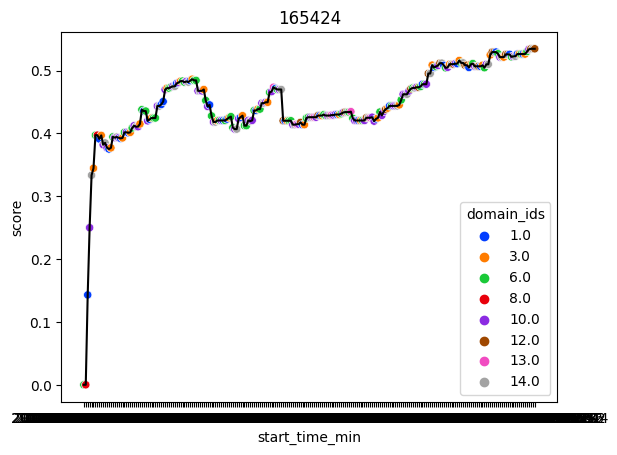

In [157]:
sns.scatterplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_ids", palette="bright").set_title(pid)
plt.plot(final_df[final_df.patient_id == pid]["start_time_min"], final_df[final_df.patient_id == pid]["score"], 'k')

Text(0.5, 1.0, '165424')

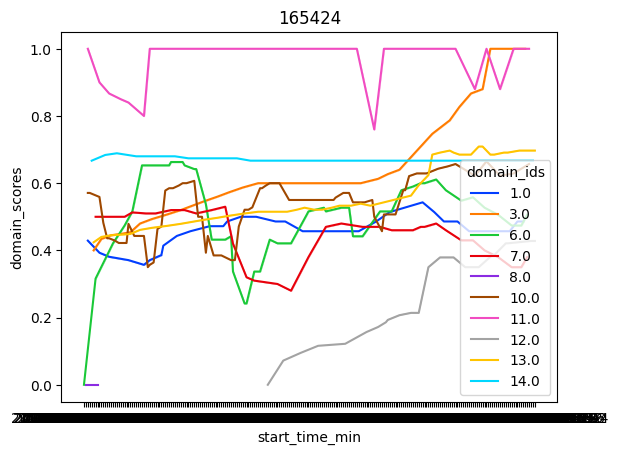

In [109]:
sns.lineplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="domain_scores", hue="domain_ids", palette="bright").set_title(pid)

Second metric calculation:
* keep other domains constant 
* how do we start off each domain -> average of when people first start out or just average

In [ ]:
df_pct

First: average across all sessions

In [ ]:
df_pct.groupby("domain_id")["percentile"].mean()

In [ ]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg(data):
    # initialize score with average
    score = [0.5 for i in range(14)]
    scores = []
    

    data = data.sort_values(by="start_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [ ]:
## get performance metric by each patient for each session
avg_final_df = df_pct.groupby("patient_id").apply(get_score_avg).reset_index(drop=True)
avg_final_df

Let's look at results

In [ ]:
import random
pid = random.choice(pd.unique(avg_final_df["patient_id"]))
print(pid)
sns.scatterplot(data=avg_final_df[avg_final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df[avg_final_df.patient_id == pid]["start_time_min"], avg_final_df[avg_final_df.patient_id == pid]["score"])

Second average method: average starting point

In [ ]:
df_pct

In [113]:
domain_avg = final_df.sort_values(by="start_time_min")
domain_avg = domain_avg.drop_duplicates(subset=["patient_id", "domain_ids"])

In [ ]:
domain_avg["domain_id"].unique()

In [114]:
lst = list(domain_avg.groupby("domain_ids")["domain_scores"].mean().reset_index()["domain_scores"])
lst

[0.45076472614536683,
 0.3584179496808111,
 0.5086372729665701,
 0.2686550432951088,
 0.11351406469760901,
 0.4388500459981601,
 0.33007643312101914,
 0.43219079685746353,
 0.28832556713672597,
 0.44116287663445136,
 0.6973070145713318,
 0.2839516585240422,
 0.4575827196858125,
 0.5561448412698412]

In [ ]:
lst = lst[:10] + [0] + lst[10:]
lst

In [ ]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg2(data):
    # initialize score with average
    global lst
    score = lst
    scores = []
    
    data = data.sort_values(by="start_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [ ]:
## get performance metric by each patient for each session
avg_final_df2 = df_pct.groupby("patient_id").apply(get_score_avg2).reset_index(drop=True)
avg_final_df2

In [ ]:
import random
pid = random.choice(pd.unique(avg_final_df2["patient_id"]))

print(pid)
sns.scatterplot(data=avg_final_df2[avg_final_df2.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df2[avg_final_df2.patient_id == pid]["start_time_min"], avg_final_df2[avg_final_df2.patient_id == pid]["score"])

Normalization

In [ ]:
df_pct

In [ ]:
sorted_df = df_pct.sort_values(by="start_time_min")
sorted_df

In [116]:
# initial score
initial = lst

In [117]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_names

['domain 1 score',
 'domain 2 score',
 'domain 3 score',
 'domain 4 score',
 'domain 5 score',
 'domain 6 score',
 'domain 7 score',
 'domain 8 score',
 'domain 9 score',
 'domain 10 score',
 'domain 11 score',
 'domain 12 score',
 'domain 13 score',
 'domain 14 score']

In [126]:
# create domain score columns, input a patient's session data
def create_domain_scores(data):
    global initial
    global column_names
    score = initial
    data = data.sort_values(by="start_time_min")
    scores = np.zeros((len(data), 14))
    i = 0

    for idx, row in data.iterrows():
        score[int(row["domain_ids"] - 1)] = row["domain_scores"]
        # set score to the score list average
        scores[i] = score
        i += 1
    data = pd.concat([data, pd.DataFrame(scores, columns=column_names)], axis=1)
    return data

In [128]:
scores_df = final_df.groupby("patient_id").apply(create_domain_scores).reset_index(drop=True)
scores_df

,level_0,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,...,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,3648085.0,56469998.0,9316748.0,14696.0,68.0,1.0,10.0,0.600,2y,1937.0,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.454,0.942
1,3648086.0,56469998.0,9316748.0,14696.0,68.0,1.0,10.0,0.600,2y,1937.0,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.703,0.942
2,3648088.0,56469998.0,9316748.0,14696.0,68.0,1.0,10.0,0.600,2y,1937.0,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.703,0.942
3,3648087.0,56469998.0,9316748.0,14696.0,68.0,1.0,10.0,0.600,2y,1937.0,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.703,0.942
4,3648929.0,56475566.0,9316749.0,14696.0,73.0,6.0,10.0,0.626,2y,1937.0,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.703,0.942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10047955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.613,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.454,0.942
10047956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.626,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.454,0.942
10047957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.652,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.454,0.942
10047958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.690,0.013,0.3,0.306,0.234,0.292,1.0,0.364,0.454,0.942


Bad pipe message: %s [b'\xca\x11\xf8\r\x01\xc2BW\xa0\x9d\xab\xa58\x1a\xe3\xb7-\xdc\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00']
Bad pipe message: %s [b'F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00']
Bad pipe message: %s [b"\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\

In [158]:
final_df.to_csv("data/domain_scores_CT.csv", index=False)

In [ ]:
# nomralize scores
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# scores only df
scores_df_minmax = MinMaxScaler().fit_transform(scores_df[column_names])

In [ ]:
minmax_df = scores_df
minmax_df[column_names] = scores_df_minmax

In [ ]:
minmax_df.columns

In [ ]:
minmax_df['score'] = minmax_df[column_names].mean(axis=1)
minmax_df

In [ ]:
avg_final_df2[avg_final_df2.patient_id == pid]

In [ ]:
minmax_df[minmax_df.patient_id == pid]

In [ ]:
import random
pid = random.choice(pd.unique(minmax_df["patient_id"]))
print(pid)
sns.scatterplot(data=minmax_df[minmax_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(minmax_df[minmax_df.patient_id == pid]["start_time_min"], minmax_df[minmax_df.patient_id == pid]["score"])

In [ ]:
temp = minmax_df[minmax_df.patient_id == pid]

In [ ]:
sns.lineplot(data=temp, x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)

In [ ]:
sns.lineplot(data=temp, x="start_time_min", y="progression_order", hue="domain_id", palette="bright").set_title(pid)

In [ ]:
temp[["domain_id", "task_type_id", "task_level", "score", "progression_order", "domain 14 score", "start_time_min", "id"]]

Create day-to-day score -> combine sessions of the same domain -> average that then average across domains -> one score for each day instead of each session

Filter out fluctations

In [ ]:
# return false if there's fluctation given a person's data
def fluctate(data):
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    d = dict()
    for idx, row in data.iterrows():
        if row["start_time"] not in d:
            d[row["start_time"]] = [row["domain_id"]]
        else:
            if row["domain_id"] in d[row["start_time"]]:
                return False
            else:
                d[row["start_time"]].append(row["domain_id"])
    return True

In [ ]:
filter_lst = minmax_df.groupby("patient_id").apply(fluctate).reset_index()

In [ ]:
filter_lst = filter_lst.rename(columns={0: "a"})
filter_lst

In [ ]:
filter_lst[filter_lst.a]["patient_id"]

In [ ]:
flutuate_data = minmax_df.loc[minmax_df["patient_id"].isin(filter_lst[filter_lst.a]["patient_id"])].reset_index()
flutuate_data

Filtering doesn't seem to work, work on incorporating accuracy

In [ ]:
df_pct

In [ ]:
def new_score(row):
    score = None
    p = [1.05, 1.0, 0.9, 0.8]
    if row.accuracy > .90:
        score = row.percentile * p[0]
    elif row.accuracy > .60:
        score = row.percentile * p[1]
    elif row.accuracy > .40:
        score = row.percentile * p[2]
    else:
        score = row.percentile * p[3]
    return score

In [ ]:
# 12 seconds
df_pscore = df_pct.copy(deep=True)
df_pscore["percentile"] = df_pscore.apply(new_score, axis=1)
df_pscore

In [ ]:
def combine(data):
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    return data.groupby(["domain_id", "start_time"])["percentile"].mean().reset_index()

In [ ]:
# create domain score columns, input a patient's session data
def create_domain_scores2(data):
    global initial
    global column_names
    score = initial
    data = data.sort_values(by="start_time_min").reset_index() # sort data by time
    i = 0
    combined_scores = combine(data)
    scores = np.zeros((len(combined_scores), 14))
    combined_scores = combined_scores.sort_values(by="start_time").reset_index()
    for idx, row in combined_scores.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores[i] = score
        i += 1
    data = data.drop_duplicates(subset=["domain_id", "start_time"]).reset_index()
    data = pd.concat([data, pd.DataFrame(scores, columns=column_names)], axis=1)
    return data

In [ ]:
df_pscore2 = df_pscore.groupby("patient_id").apply(create_domain_scores2).reset_index(drop=True)
df_pscore2

In [ ]:
column_n = column_names

In [ ]:
scores_df_minmax2 = MinMaxScaler().fit_transform(df_pscore2[column_n])

In [ ]:
minmax_df2 = df_pscore2
minmax_df2[column_n] = scores_df_minmax2

In [ ]:
minmax_df2['score'] = minmax_df2[column_n].mean(axis=1)
minmax_df2

In [ ]:
import random
pid = random.choice(pd.unique(minmax_df2["patient_id"]))
print(pid)
sns.scatterplot(data=minmax_df2[minmax_df2.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(minmax_df2[minmax_df2.patient_id == pid]["start_time_min"], minmax_df2[minmax_df2.patient_id == pid]["score"], 'k')

In [ ]:
minmax_df2

In [ ]:
temp = df_pct[df_pct.patient_id == 30679]
temp = temp.sort_values(by="start_time_min").reset_index()
temp[temp.domain_id == 10][["accuracy", "progression_order", "percentile"]][temp.progression_order == 3]

In [ ]:
temp = create_domain_scores2(df_pscore[df_pscore.patient_id == 87299])
temp[temp.domain_id == 4][["accuracy", "progression_order", "domain 4 score", "start_time"]]